In [1]:
!pip install -q kaggle
!pip install transformers
!pip install unidecode
!pip install torch
!pip install tqdm
!pip install scikit-learn==0.22.2
!pip install livelossplot==0.5.4

In [2]:
from google.colab import files
from tqdm import tqdm
tqdm.pandas()
import random
import time
random.seed(int(time.time()))
from torch.utils.data import Dataset,DataLoader
import torch
from torch import nn, utils
import torch.nn.functional as F
from torch.autograd import Variable 
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pandas as pd
import numpy as np
from transformers import BertTokenizer
import nltk
nltk.download('punkt')
nltk.download('stopwords') 
import unidecode
import re
from nltk.corpus import stopwords
import string
import seaborn as sns
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from torch.utils.tensorboard import SummaryWriter
from livelossplot import PlotLosses
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"gabib3b","key":"817d7e169db4cbef867b22907320144c"}'}

In [4]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c home-depot-product-search-relevance

mkdir: cannot create directory ‘/root/.kaggle’: File exists
relevance_instructions.docx: Skipping, found more recently modified local copy (use --force to force download)
sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
attributes.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
product_descriptions.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!ls

 attributes.csv.zip   product_descriptions.csv.zip   sample_submission.csv.zip
'kaggle (1).json'     relevance_instructions.docx    test.csv.zip
 kaggle.json	      sample_data		     train.csv.zip


In [6]:
att_df= pd.read_csv('attributes.csv.zip')
desc_df= pd.read_csv('product_descriptions.csv.zip')
df = pd.read_csv('train.csv.zip', encoding='latin-1')
test_df = pd.read_csv('test.csv.zip',encoding='latin-1')


In [7]:
desc_df = desc_df.fillna(0)
df = df.fillna(0)
test_df = test_df.fillna(0)
att_df = att_df.fillna(0)

desc_df['product_uid'] = desc_df['product_uid'].astype(np.int64)
df['product_uid'] = df['product_uid'].astype(np.int64)
test_df['product_uid'] = test_df['product_uid'].astype(np.int64)
att_df['product_uid'] = att_df['product_uid'].astype(np.int64)

In [8]:
df.sample(2)

,id,product_uid,product_title,search_term,relevance
47685,144826,153188,American Standard Cadet 6 ft. Whirlpool Tub in...,6 ft whirlpool tub,3.00
51532,156520,159777,International Concepts Unfinished Counter Heig...,aluminum outdoor counter height table,2.33


In [9]:
df.describe()

,id,product_uid,relevance
count,74067.000000,74067.000000,74067.000000
mean,112385.709223,142331.911553,2.381634
std,64016.573650,30770.774864,0.533984
min,2.000000,100001.000000,1.000000
25%,57163.500000,115128.500000,2.000000
50%,113228.000000,137334.000000,2.330000
75%,168275.500000,166883.500000,3.000000
max,221473.000000,206650.000000,3.000000


In [10]:
sorted(pd.unique(df['relevance']).tolist())

[1.0, 1.25, 1.33, 1.5, 1.67, 1.75, 2.0, 2.25, 2.33, 2.5, 2.67, 2.75, 3.0]

In [13]:
df.drop_duplicates(["product_uid"]).shape[0]/len(df)

0.7380749861611784

In [14]:
EMPTY_STRING = ''
SPACE = ' '
def clean_text(string):
  if string is None:
    return None

  string = string.strip().lower()
  string = unidecode.unidecode(string)
  string = string.replace("'", EMPTY_STRING)
  string = re.sub(r"\'n", SPACE, string)
  string = re.sub(r"\'s", " 's", string)
  string = re.sub(r"\'ve", " 've", string)
  string = re.sub(r"n\'t", " n't", string)
  string = re.sub(r"\'re", " 're", string)
  string = re.sub(r"\'d", " 'd", string)
  string = re.sub(r"\'ll", " 'll", string)
  string = re.sub(r",", " , ", string)
  string = re.sub(r"!", " ! ", string)
  string = re.sub(r"\(", " ( ", string)
  string = re.sub(r"\)", " ) ", string)
  string = re.sub(r"\?", r" \? ", string)
  string = re.sub(r"\s{2,}", SPACE, string)
  string = re.sub(r" +", SPACE, string)
  string = re.sub(r"/", " / ", string)
  string = re.sub(r"\|", " | ", string)
  string = re.sub(r"-", " - ", string)
  string = re.sub(r"\+", " + ", string)
  string = re.sub(r"\\\\", SPACE, string)

  return string.strip()


In [15]:
_characters_to_clean = string.punctuation + "''"
EN_STOP_WORDS = set(stopwords.words('english')) - set(['can', 'no', 'up', 'against', 'after', 'before', 'below'])

PUNCTUATIONS = '!"#$&\'()*+,-./:;<=>?@[\\]^_`{|}~'

PUNCTUATIONS_PATTERN = re.compile("[{}]+$".format(re.escape(PUNCTUATIONS)))

from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()

def _is_punctuation_only(word: str):
    return PUNCTUATIONS_PATTERN.match(word)

def filter_ale_punctuation(words):
    return [word for word in words if not _is_punctuation_only(word)] if words is not None else None

def tokenize(text):
  
  processed_text = clean_text(text)
  tokens = nltk.word_tokenize(processed_text)

  
  tokens = [stemmer.stem(word) for word in tokens]
  tokens = [word for word in tokens if word not in _characters_to_clean and word not in EN_STOP_WORDS]
  tokens = filter_ale_punctuation(tokens)
  tokens = [re.sub("\d", "#", word) for word in tokens]

  return tokens if len(tokens) > 0 else None


In [16]:
df['product_title_tokens'] = df['product_title'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:35<00:00, 2095.65it/s]


In [17]:
df['search_term_tokens'] = df['search_term'].progress_apply(tokenize)

100%|██████████| 74067/74067 [00:13<00:00, 5564.78it/s]


In [18]:
test_df['product_title_tokens'] = test_df['product_title'].progress_apply(tokenize)


100%|██████████| 166693/166693 [01:16<00:00, 2166.64it/s]


In [19]:
test_df['search_term_tokens'] = test_df['search_term'].progress_apply(tokenize)

100%|██████████| 166693/166693 [00:30<00:00, 5548.84it/s]


In [31]:
original_train_df_length = len(df)
df = df[df['search_term_tokens'].notnull()]
len(df)/original_train_df_length

0.9997299742125373

In [32]:
df.sample(3)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
29243,89584,127099,GE 1.4 cu. ft. Countertop Microwave in White,ge countertop microwave,3.00,"[ge, #.#, cu, ft., countertop, microwav, white]","[ge, countertop, microwav]",6
18003,55553,114572,Whirlpool Duet 7.3 cu. ft. High-Efficiency Ele...,gazhose for dryer machine,1.33,"[whirlpool, duet, #.#, cu, ft., high, effici, ...","[gazhos, dryer, machin]",1
47659,144725,153136,Allied Tube &amp; Conduit 1 in. EMT Conduit,hold downs electrical metal pipe,1.67,"[alli, tube, amp, conduit, #, emt, conduit]","[hold, electr, metal, pipe]",2


In [33]:
all_words = [word for words in df['search_term_tokens'].tolist() for word in words]
all_words.extend([word for words in df['product_title_tokens'].tolist() for word in words])

In [34]:
WORD_REPLACE_MENT = '<word>'
PAD_WORD = "<pad>"
MIN_WORD_COUNT = 3

In [39]:

counts = Counter(all_words)

In [40]:
vocab_words = set(all_words)
vocab_size_before_threshold = len(vocab_words)
vocab_words = {word for word in vocab_words if counts[word] >= MIN_WORD_COUNT}
vocab_size_before_threshold, len(vocab_words), len(all_words)

(16345, 10327, 1055648)

In [41]:
df['product_title_tokens'] = df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 271976.22it/s]


In [42]:
df['search_term_tokens'] = df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])

100%|██████████| 74047/74047 [00:00<00:00, 503104.77it/s]


In [43]:
test_df['product_title_tokens'] = test_df['product_title_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words])
test_df['search_term_tokens'] = test_df['search_term_tokens'].progress_apply(lambda words: [word if word in vocab_words else WORD_REPLACE_MENT for word in words] if words is not None else [])

100%|██████████| 166693/166693 [00:00<00:00, 286512.56it/s]


In [44]:
df[df['product_title_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class


In [45]:
df[df['search_term_tokens'].map(len) == 0]

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class


In [46]:
vocab = {word: index + 2 for (index, word) in enumerate(vocab_words - {PAD_WORD, WORD_REPLACE_MENT})}
vocab[PAD_WORD] = 0 
vocab[WORD_REPLACE_MENT] = 1
PAD_WORD_ID = vocab[PAD_WORD]

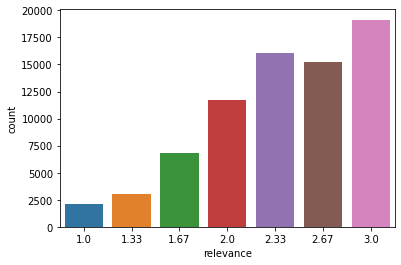

In [48]:
ax = sns.countplot(x="relevance", data=df)

In [49]:
len(pd.unique(df['relevance']))

7

In [50]:
mapping = {1.25: 1.33, 1.5: 1.67, 1.75: 2.0, 2.25: 2.33, 2.5: 2.67, 2.75: 3.0}
df['relevance'] = df['relevance'].apply(lambda relevance: mapping[relevance] if relevance in mapping else relevance)
len(pd.unique(df['relevance']))

7

In [51]:
relevance_values = sorted(pd.unique(df['relevance']).tolist())

relevance_map = {relevance: index for (index, relevance) in enumerate(relevance_values)}
num_of_classes = len(relevance_map)
num_of_classes, relevance_map 

(7, {1.0: 0, 1.33: 1, 1.67: 2, 2.0: 3, 2.33: 4, 2.67: 5, 3.0: 6})

In [52]:
cls_to_score = {cls: score for (score, cls) in relevance_map.items()}
cls_to_score

{0: 1.0, 1: 1.33, 2: 1.67, 3: 2.0, 4: 2.33, 5: 2.67, 6: 3.0}

In [53]:
df['relevance_class'] = df['relevance'].apply(lambda relevance: relevance_map[relevance])
pd.unique(df['relevance_class'])

array([6, 5, 4, 3, 0, 2, 1])

In [55]:
token_id_to_word = {id: word for (word, id) in vocab.items()}
len(token_id_to_word), len(vocab)

(10329, 10329)

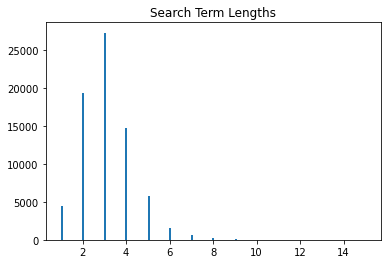

In [57]:
search_term_lengths = df['search_term_tokens'].map(len).tolist()
_ = plt.hist(search_term_lengths, bins='auto')  # arguments are passed to np.histogram
plt.title("Search Term Lengths")
plt.show()

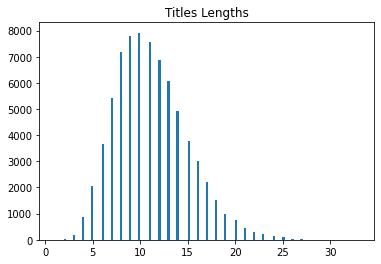

In [58]:
title_lengths = df['product_title_tokens'].map(len).tolist()
_ = plt.hist(title_lengths, bins='auto') 
plt.title("Titles Lengths")
plt.show()

In [59]:
MAX_SEARCH_TERM_LENGTH = 5
MAX_TITLE_LENGTH = 15

In [60]:
class DatasetLoader(Dataset):

    def __init__(self, df, vocab):
        self._df = df
        self._vocab = vocab

    def __len__(self):
        return len(self._df)

    def _fix_words(self, words_ids, required_size):
        if len(words_ids) > required_size:
            words_ids = words_ids[0: required_size]
        elif len(words_ids) < required_size:
            b = np.zeros(required_size - len(words_ids), dtype=int)
            words_ids = np.concatenate((words_ids, b), axis=None)

        return words_ids

    def __getitem__(self, idx):
        row = self._df.iloc[idx]

        search_term = np.array([self._vocab[w] for w in row['search_term_tokens']])
        search_term_length = min(len(search_term), MAX_SEARCH_TERM_LENGTH)
        search_term = self._fix_words(search_term, MAX_SEARCH_TERM_LENGTH)


        product_title = np.array([self._vocab[w] for w in row['product_title_tokens']])
        product_title_length = min(len(product_title), MAX_TITLE_LENGTH)
        product_title = self._fix_words(product_title, MAX_TITLE_LENGTH)

   

        return row['id'], search_term, search_term_length, product_title, product_title_length, row['relevance_class']
    


In [61]:
df.sample(1)

,id,product_uid,product_title,search_term,relevance,product_title_tokens,search_term_tokens,relevance_class
70182,210305,197214,Samsung 25.5 cu. ft. French Door Refrigerator ...,black refrigeratore,3.0,"[samsung, ##.#, cu, ft., french, door, refrige...","[black, refrigerator]",6


In [62]:
BATCH_SIZE = 64

In [63]:
test_df['relevance_class'] = -1

In [64]:
training_df, validation_df = train_test_split(df, test_size=0.1, random_state=42)
len(training_df)+ len(validation_df), len(df)

(74047, 74047)

In [66]:

training_df = training_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance', 'relevance_class']]
data_loader = DatasetLoader(training_df, vocab)

train_data_loader = torch.utils.data.DataLoader(data_loader,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


validation_data_df = validation_df[['id', 'product_title_tokens', 'search_term_tokens', 'relevance', 'relevance_class']]
validation_dataset = DatasetLoader(validation_data_df, vocab)

valiodation_data_loader = torch.utils.data.DataLoader(validation_dataset,
                                                 batch_size=BATCH_SIZE, shuffle=True, 
                                                 num_workers=4,drop_last=False)


test_df_fixed = test_df[(test_df['search_term_tokens'].map(len) > 0) & (test_df['product_title_tokens'].map(len) > 0)]


test_loader = DatasetLoader(test_df_fixed[['id', 'product_title_tokens', 'search_term_tokens', 'relevance_class']], vocab)

test_data_loader = torch.utils.data.DataLoader(test_loader,
                                                 batch_size=BATCH_SIZE, shuffle=False, 
                                                 num_workers=4,drop_last=False)

len(data_loader), len(test_loader)

(66642, 166659)

In [67]:
class EncoderModel(nn.Module):

    def __init__(self, n_vocab):
        super(EncoderModel, self).__init__()
        self.lstm_size = 100
        self.embedding_dim = 300
        self.lstm_dim_size = 200
        

        self.embedding = nn.Embedding(
            num_embeddings=n_vocab,
            embedding_dim=self.embedding_dim,
        )

        self.rnn = nn.LSTM(self.embedding_dim, 300, 1, bidirectional=True, batch_first=True)
        self.fc1 = nn.Linear(600, 300)
        self.d1 = nn.Dropout(p=0.4)


   
    def forward(self, x, lengths):

        embed = self.embedding(x)
            
        packed_input = pack_padded_sequence(embed, lengths, batch_first=True, enforce_sorted=False)
        
        packed_output, hn = self.rnn(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        
        out_forward = output[range(len(output)), lengths - 1, :self.embedding_dim ]
        out_reverse = output[:, 0, self.embedding_dim :]
        out = torch.cat((out_forward, out_reverse), 1)
        out = self.d1(out)
        out = self.fc1(out)
        out = torch.tanh(out)

        return out
    
    def reset_parameters(self):
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc1.bias)
        nn.init.uniform_(self.embedding.weight, -1.0, 1.0)
        

        for name, param in self.rnn.named_parameters():
            if 'weight_ih' in name:
                torch.nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                torch.nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
        

class RelevanceModel(nn.Module):

  def __init__(self, n_vocab, num_of_classes):
    super(RelevanceModel, self).__init__()
    self.query_encoder = EncoderModel(n_vocab)
    self.title_encoder = EncoderModel(n_vocab)
    self.fc = nn.Linear(600, num_of_classes)
    self.d1 = nn.Dropout(p=0.4)

  def  forward(self, queries, titles, queries_lengths, titles_lengths):
    encoded_queries = self.query_encoder(queries, queries_lengths)
    title_encoded = self.title_encoder(titles, titles_lengths)
    

    out = torch.cat((encoded_queries, title_encoded), 1)  
    out = self.d1(out)

    out = self.fc(out)
    
    return out 


  def reset_parameters(self):
    nn.init.uniform_(self.fc.weight)
    nn.init.uniform_(self.fc.bias)
    self.query_encoder.reset_parameters()
    self.title_encoder.reset_parameters()
  

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [70]:
weights = compute_class_weight('balanced', pd.unique(df['relevance_class']), df['relevance_class'].tolist())
weights

array([0.55278757, 0.69497029, 0.65829503, 0.90126462, 5.0396107 ,
       1.56111908, 3.51550112])

In [71]:
learnniong_rate = 0.0001
model = RelevanceModel(len(vocab), num_of_classes)
model.reset_parameters()
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learnniong_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learnniong_rate)

class_weights=torch.tensor(weights,dtype=torch.float)

criterion = torch.nn.CrossEntropyLoss(weight = class_weights, reduction='sum').to(device)


In [73]:
import matplotlib.pyplot as plt

def train_epoc(epoc):

  model.train()
  running_loss = 0.0
  counter = 0.0
  correct_classified = 0.0 

  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    target_relevance_score = Variable(target_relevance_score).float().to(device)

    optimizer.zero_grad()

    scores = model(search_term, product_title, search_term_length,  product_title_length)
    loss = criterion(scores, target_relevance_score.long())

      

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    counter += search_term.shape[0]
    correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())

  return running_loss/counter, correct_classified/counter



def validation():
  model.eval()

  running_loss  = 0.0
  counter = 0.0

  correct_classified = 0.0 

  with torch.no_grad():
    for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in valiodation_data_loader:
      search_term = Variable(search_term).to(device)
      product_title = Variable(product_title).to(device)
      target_relevance_score = Variable(target_relevance_score).float().to(device)
      scores = model(search_term, product_title, search_term_length,  product_title_length)

    
      
      loss = criterion(scores, target_relevance_score.long())
      running_loss += loss.item()
      counter += search_term.shape[0]
      correct_classified += np.sum(torch.argmax(scores, dim=1).cpu().detach().numpy()== target_relevance_score.cpu().numpy())
  
  return running_loss/counter, correct_classified/counter


  


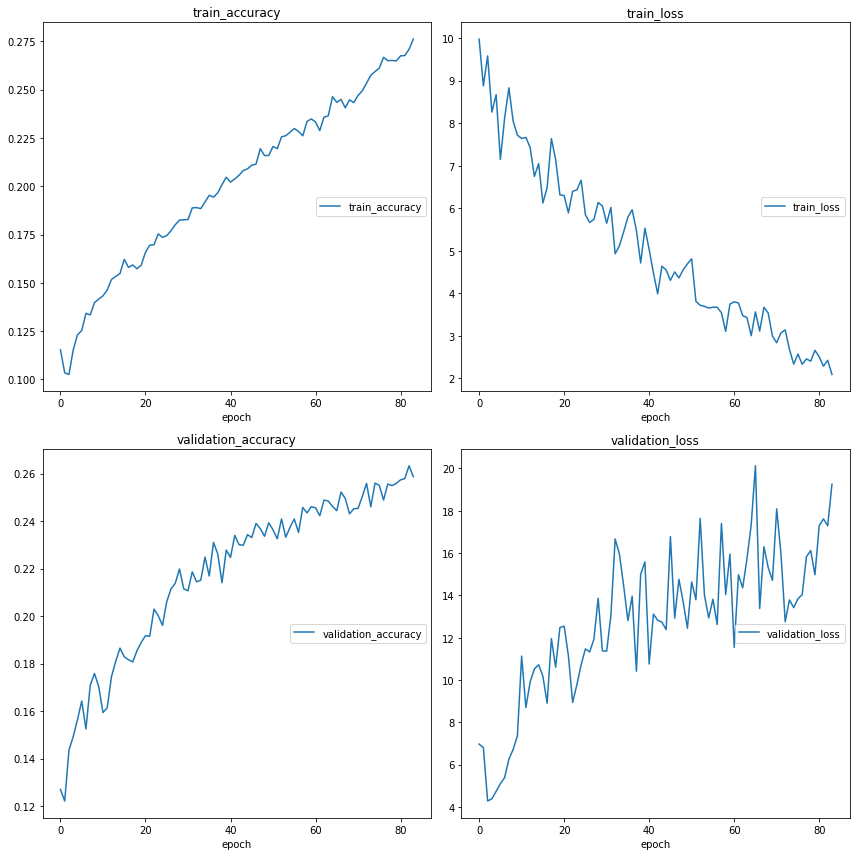

train_accuracy
	train_accuracy   	 (min:    0.103, max:    0.276, cur:    0.276)
train_loss
	train_loss       	 (min:    2.095, max:    9.974, cur:    2.095)
validation_accuracy
	validation_accuracy 	 (min:    0.122, max:    0.263, cur:    0.259)
validation_loss
	validation_loss  	 (min:    4.281, max:   20.128, cur:   19.257)


In [ ]:
liveloss = PlotLosses()

for epoc in range(10000):

  train_loss, train_accuracy = train_epoc(epoc)
  validation_loss, val_accuracy = validation()

  liveloss.update({
          'train_loss': train_loss,
          'validation_loss': validation_loss,

          'train_accuracy': train_accuracy,
          'validation_accuracy': val_accuracy
      })
    
  liveloss.draw()


In [ ]:
r1 = np.sum(torch.argmax(scores, dim=1).detach().cpu().numpy() == target_relevance_score.numpy())

In [ ]:
r1, scores.shape

(52, torch.Size([64, 13]))

In [ ]:


model.eval()
test_scores = []
test_ids =[]
tt = []

with torch.no_grad():
  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in train_data_loader:
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title, search_term_length,  product_title_length)

    test_scores.extend(scores.detach().cpu().numpy().flatten().tolist())
    test_ids.extend(ids.numpy().tolist())
    tt.extend(target_relevance_score.numpy().tolist())

    break
  



In [ ]:
for _ in test_data_loader:
  break

In [ ]:
model.eval()
test_scores = []
test_ids =[]
tt = []
test_data = []
with torch.no_grad():
  for ids, search_term, search_term_length, product_title, product_title_length, target_relevance_score in test_data_loader:
     
    search_term = Variable(search_term).to(device)
    product_title = Variable(product_title).to(device)
    

    scores = model(search_term, product_title, search_term_length,  product_title_length)

    vals = torch.argmax(scores, dim=1).flatten().detach().cpu().numpy().tolist()
    ids = ids.numpy().tolist()

    test_data.extend(zip(ids, vals))



    
  

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1320, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Traceback (most recent call last):
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1328, in __del__
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f5061e734d0>
Trac

In [ ]:
# 166693, len(test_data), len(test_df)
all_ids = {x for (x, _) in test_data}

for _, row in test_df.iterrows():
  if row['id'] not in all_ids:
    test_data.append((row['id'], 1))
    
len(test_data)

166693

In [ ]:
pd.DataFrame([(id, cls_to_score[cls]) for (id, cls) in test_data], columns = ["id", "relevance"]).to_csv("test_res.csv", index=  False)

In [ ]:
from google.colab import files
files.download('test_res.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
test_df.sample(1)

,id,product_uid,product_title,search_term,product_title_tokens,search_term_tokens,my_relevance
107023,159578,161578,Speedi-Products 7 in. 24-Gauge Single Wall Stove Pipe 90 Degree Adjustable Elbow in Black Matte,singel wall stove pipe,"[speedi, product, #, ##, gaug, singl, wall, stove, pipe, ##, degre, adjust, elbow, black, matt]","[singel, wall, stove, pipe]",1
